**Model for rented bike demand forecasting**

In [ ]:
#libraries import
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import json #for dict to string conversion"
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import ElasticNet
import matplotlib.dates as md
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.ticker as ticker
from sklearn.linear_model import ElasticNet,ElasticNetCV
sns.set_theme()
pd.set_option('display.max_columns', 48)

In [ ]:
#reading the data ,data should be uploaded in colab.
df= pd.read_csv('SeoulBikeData_MP1.csv', encoding='ISO-8859-1') 

In [ ]:
df.head()

,Unnamed: 0,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,0,01/12/17,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1,01/12/17,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2,01/12/17,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,3,01/12/17,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,4,01/12/17,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                8760 non-null   int64  
 1   Date                      8760 non-null   object 
 2   Rented Bike Count         8760 non-null   int64  
 3   Hour                      8760 non-null   int64  
 4   Temperature(C)            8260 non-null   float64
 5   Humidity(%)               8760 non-null   int64  
 6   Wind speed (m/s)          8760 non-null   float64
 7   Visibility (10m)          8760 non-null   int64  
 8   Dew point temperature(C)  8760 non-null   float64
 9   Solar Radiation (MJ/m2)   8760 non-null   float64
 10  Rainfall(mm)              8760 non-null   float64
 11  Snowfall (cm)             8760 non-null   float64
 12  Seasons                   8760 non-null   object 
 13  Holiday                   8760 non-null   object 
 14  Function

Temperature has null values.

We can fill the null values in temperature by different methods

In the data, date is in the form of dd/mm/yy. We need to change it into datetime

In [ ]:
df['Date']= pd.to_datetime(df['Date'], format='%d/%m/%y')

In [ ]:
df.rename(columns={'Rented Bike Count':'Count'}, inplace=True)

In [ ]:
df.head()

,Unnamed: 0,Date,Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
#Dropping unrequired column
df=df.drop('Unnamed: 0', axis=1)

In the data,there are 6 categorical variables-Seasons,Holiday,Functioning Day,Weekend,weekday and Month.For better representation,we can convert categorical variables to categorical data type.

In [ ]:
df['Seasons'] =pd.Categorical(df['Seasons'], categories=['Winter', 'Spring', 
             'Summer', 'Autumn'], ordered=True)

df['Holiday'] = pd.Categorical(df['Holiday'], categories=['No Holiday', 'Holiday'])
df['Functioning Day'] = pd.Categorical(df['Functioning Day'], categories=['No', 'Yes'])

#from date we can extract the details of weekday,weekend and month
df['Weekday'] = pd.Categorical(df['Date'].dt.day_name(), categories=['Monday', 'Tuesday', 
             'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
df['Weekend'] = (df['Weekday'].cat.codes >= 5).astype(int)
df['Month'] = pd.Categorical(df['Date'].dt.month_name(), categories=['January', 'February', 
             'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October',
             'November', 'December'], ordered=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      8760 non-null   datetime64[ns]
 1   Count                     8760 non-null   int64         
 2   Hour                      8760 non-null   int64         
 3   Temperature(C)            8260 non-null   float64       
 4   Humidity(%)               8760 non-null   int64         
 5   Wind speed (m/s)          8760 non-null   float64       
 6   Visibility (10m)          8760 non-null   int64         
 7   Dew point temperature(C)  8760 non-null   float64       
 8   Solar Radiation (MJ/m2)   8760 non-null   float64       
 9   Rainfall(mm)              8760 non-null   float64       
 10  Snowfall (cm)             8760 non-null   float64       
 11  Seasons                   8760 non-null   category      
 12  Holiday             

Now let's do some expaloratory analysis to the data.

Plotting date vs count

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


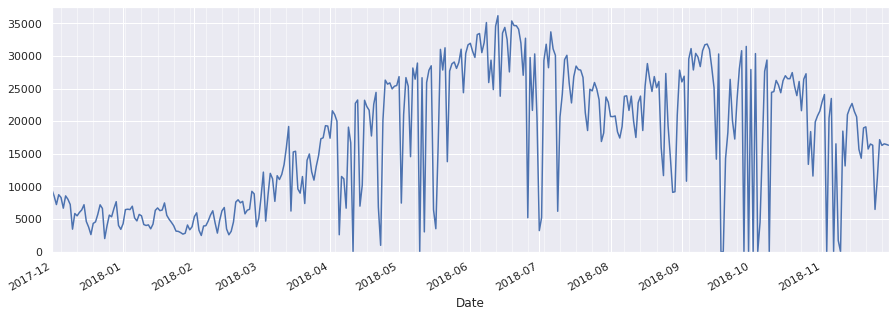

In [ ]:
#in first examples we play with groupby
by_day = df.groupby(['Date'])['Count'].sum()
fig, ax1 = plt.subplots(1,1, figsize=(15,5))
sns.lineplot(by_day.index, by_day.values, ax=ax1)
fig.autofmt_xdate()
ax1.xaxis.set_major_locator(md.MonthLocator(bymonthday = 1))
ax1.set_xlim(md.datestr2num(("2017/12/01", "2018/11/30")))
ax1.set_ylim((0, 37500))
ax1.xaxis.set_minor_locator(md.WeekdayLocator(byweekday = 1))
ax1.grid(b=True, which='minor', color='white', lw=0.5)

There is increase of count with time that seems to not only be season dependent. Let's extract data from date

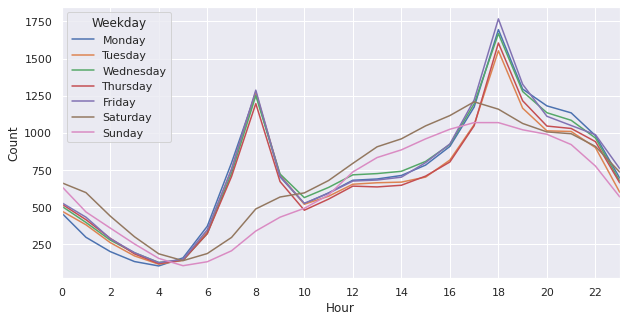

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.lineplot(x='Hour', y='Count', data=df, hue='Weekday', ci=None)
ax1.set_xlim((0,23))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(2))

Count behave differently on weekends.So we can drop weekday column and keep only weekend.

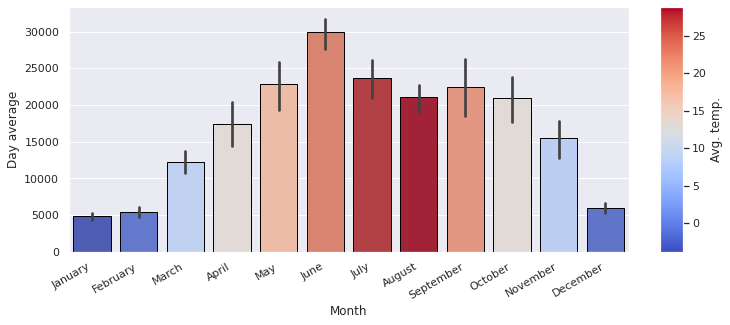

In [ ]:
#Day average per month
by_month = df.groupby(['Date'])['Count'].agg(['sum'])
by_month = by_month.reset_index()
by_month['Month'] = pd.Categorical(by_month['Date'].dt.month_name(), categories=['January', 'February', 
             'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October',
             'November', 'December'], ordered=True)
#set colors of bars accordingly to mean temperature
temp_month = df.groupby(['Month'])['Temperature(C)'].agg(['mean'])
temp_month_a = 100*(temp_month - temp_month.min())/(temp_month.max() - temp_month.min())
col_pal = sns.color_palette("coolwarm", 101)
colors = []
for x in temp_month_a.round().values.astype(int).T[0]:
    colors.append(col_pal[x])
#plot bars
fig = plt.figure(figsize=(11, 5), facecolor='w', edgecolor='k')
gs = fig.add_gridspec(1, 23)
#Residual vs. fitted
ax1 = fig.add_subplot(gs[0, :21])
ax2 = fig.add_subplot(gs[0, 22])
sns.barplot(x='Month', y='sum', data=by_month, ax=ax1, palette=colors, edgecolor=(0,0,0))
ax1.set_ylabel("Day average")
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=temp_month.min(), vmax=temp_month.max())
cb1 = mpl.colorbar.ColorbarBase(ax=ax2, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Avg. temp.')
fig.autofmt_xdate()

It seem that usage of bikes is highly related with temperature but July/August are vacation weeks so the usage drops in that time

Text(0, 0.5, 'Avg. temp.')

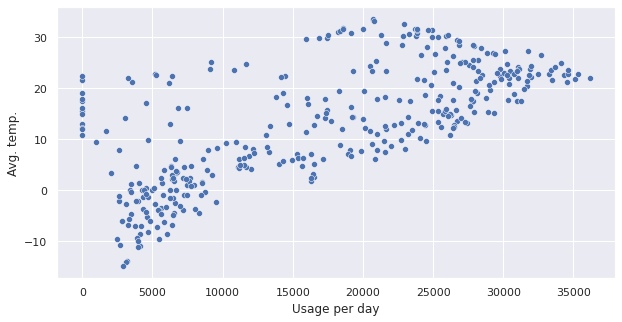

In [ ]:
count_day = df.groupby(['Date'])['Count'].agg(['sum'])
temp_day = df.groupby(['Date'])['Temperature(C)'].agg(['mean']) 
db = pd.concat([count_day, temp_day], axis=1).reset_index()
fig, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.scatterplot(x='sum', y='mean', data=db, ax=ax1)
ax1.set_xlabel("Usage per day")
ax1.set_ylabel("Avg. temp.")

Bike usage increases with the increase of temeprature

Text(0, 0.5, 'Avg. rainfall')

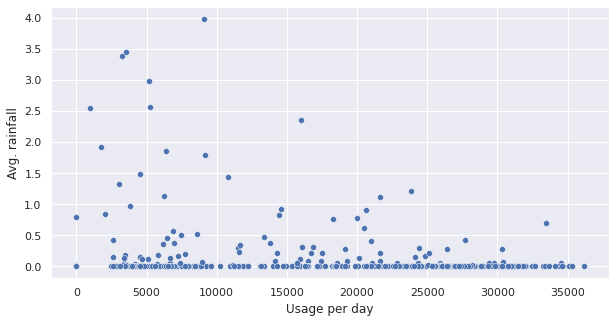

In [ ]:
#rainfall vs bike usage
count_day = df.groupby(['Date'])['Count'].agg(['sum'])
temp_day = df.groupby(['Date'])['Rainfall(mm)'].agg(['mean']) 
db = pd.concat([count_day, temp_day], axis=1).reset_index()
fig, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.scatterplot(x='sum', y='mean', data=db, ax=ax1)
ax1.set_xlabel("Usage per day")
ax1.set_ylabel("Avg. rainfall")

There seem to be a trend of decrease of bikes usage with the increase of avg. rainfall

Text(0, 0.5, 'Avg. snowfall')

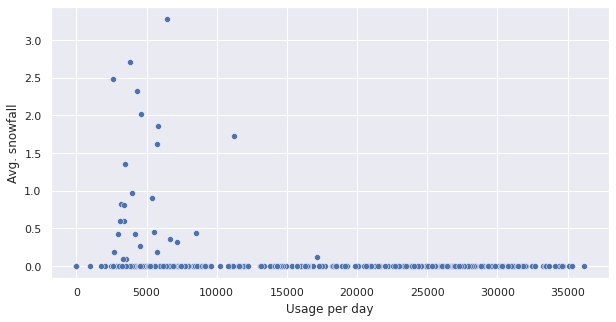

In [ ]:
#snowfall vs bike usage
count_day = df.groupby(['Date'])['Count'].agg(['sum'])
temp_day = df.groupby(['Date'])['Snowfall (cm)'].agg(['mean']) 
db = pd.concat([count_day, temp_day], axis=1).reset_index()
fig, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.scatterplot(x='sum', y='mean', data=db, ax=ax1)
ax1.set_xlabel("Usage per day")
ax1.set_ylabel("Avg. snowfall")

Snowfall has negative effect on bikes usage

Text(0, 0.5, 'Avg. windspeed')

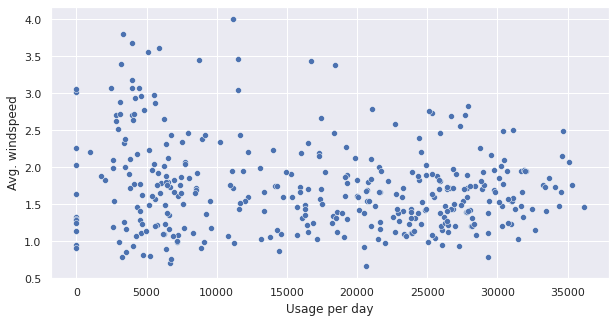

In [ ]:
#windspeed vs bike usage
count_day = df.groupby(['Date'])['Count'].agg(['sum'])
temp_day = df.groupby(['Date'])['Wind speed (m/s)'].agg(['mean']) 
db = pd.concat([count_day, temp_day], axis=1).reset_index()
fig, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.scatterplot(x='sum', y='mean', data=db, ax=ax1)
ax1.set_xlabel("Usage per day")
ax1.set_ylabel("Avg. windspeed")

Windspeed has little to no effect on bikes usage

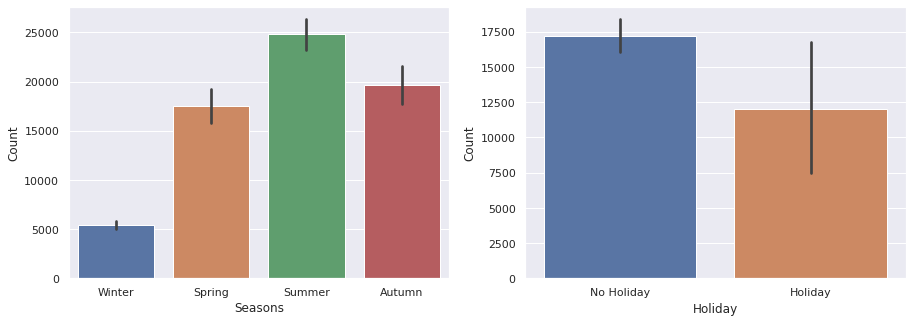

In [ ]:
#Two more averages of day sum: season and holiday.
#this time lets try resample instead of group aggregations.
#First make a separate timeseries with hours
df_p = pd.DataFrame({'Date': df['Date'] + df['Hour'].astype('timedelta64[h]'),
              'Seasons': df['Seasons'], 'Holiday': df['Holiday'], 'Count': df['Count']})
df_p.set_index('Date', inplace = True)
#now resample per day with separate function for different categories
df_p = df_p.resample('1D').agg({'Seasons': 'first', 'Holiday': 'first', 'Count': 'sum'})
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.barplot(x='Seasons', y='Count', data=df_p, ax=axs[0])
sns.barplot(x='Holiday', y='Count', data=df_p, ax=axs[1])

bikes usage is bigger in summer and when there is no holidays(people are working and going to schools)

In [ ]:
#dropping unrequired column
#We have extracted detils from the date, now we can drop it.
df=df.drop("Date",axis=1)

#dropping unrequired column
#df=df.drop("Weekday",axis=1)

In [ ]:
df.head()

,Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Weekday,Weekend,Month
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,Friday,0,December
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,Friday,0,December
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,Friday,0,December
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,Friday,0,December
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,Friday,0,December


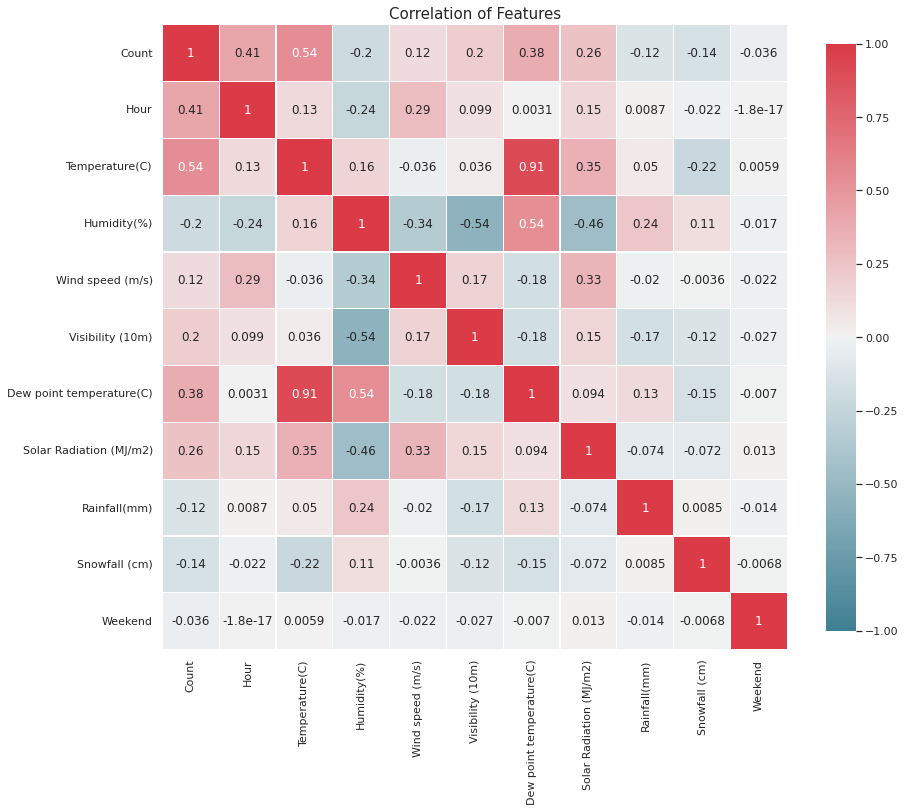

In [ ]:
#%% Heatmap of data
def correlation_heatmap(df_new):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df_new.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmin = -1.0, vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Correlation of Features', y=1.05, size=15)
    #return(df_new.corr)
correlation_heatmap(df)

In [ ]:
#How much count is related to each variables.
df.corr()["Count"]

Count                       1.000000
Hour                        0.410257
Temperature(C)              0.540538
Humidity(%)                -0.199780
Wind speed (m/s)            0.121108
Visibility (10m)            0.199280
Dew point temperature(C)    0.379788
Solar Radiation (MJ/m2)     0.261837
Rainfall(mm)               -0.123074
Snowfall (cm)              -0.141804
Weekend                    -0.036467
Name: Count, dtype: float64

From the correlation map,we can observe that Rainfall and snowfall has negative effect on the count.Since the magnitudes of these correlation values are less,precipitation has littile effect on count.

In [ ]:
#categorical datatype to object data type
df['Seasons'] = df['Seasons'].astype('object')
df['Holiday'] = df['Holiday'].astype('object')
df['Functioning Day'] = df['Functioning Day'].astype('object')
df['Weekday'] = df['Weekday'].astype('object')
df['Month'] = df['Month'].astype('object')

In [ ]:
def train_test(df):
#splitting of test and train data
  train,test= train_test_split(df,test_size=0.20, random_state=47,stratify=df['Hour'])
  return(train,test)

In [ ]:
#train,test=train_test(df)  #split the test-train data

Here we are using different encoding techniques for categorical variables.
 
a)encoding of categorical variables by cat.codes

b)ordinal encoding.

Different models to fill null values of Temperature.

a)simple imputer

b)knn imputer

c)iterative imputer

In [ ]:
def cyclic(df):
  #hour, weekday and month are cyclical feature and it is beneficial to include it into encoding by use of trignometric functions
  df['Hour_sin'] = np.sin(df['Hour']*(2.*np.pi/24))
  #df['Weekday_sin'] = np.sin(df['Weekday']*(2.*np.pi/7))
  df.drop(['Hour'], axis=1, inplace=True)
  return(df)

In [ ]:
train,test=train_test(df)

In [ ]:
#hour to cyclic
train_c,test_c=cyclic(train),cyclic(test)

In [ ]:
train,test=train_c,test_c

In [ ]:
def train_test(train,test):
  numerical_col = []
  categorical_col =[]

  train_y=train.iloc[:,0]
  test_y=test.iloc[:,0]
  columns =train.columns
  columns=columns[1:] #removing target

  [numerical_col.append(column) for column in columns if train[column].dtype=="int64"]
  [numerical_col.append(column) for column in columns if train[column].dtype=="float64"]
  [categorical_col.append(column) for column in columns if train[column].dtype=="object"]

  numerical_data_pipeline = Pipeline([("imputer",KNNImputer(n_neighbors=6, weights='uniform', metric='nan_euclidean')),
                                    ("std_scaler", StandardScaler())])

  categorical_data_pipeline = Pipeline([("one_hot_encoder", OneHotEncoder())])
  transformation_pipeline = ColumnTransformer([("num", numerical_data_pipeline, numerical_col),
                                             ("cat", categorical_data_pipeline, categorical_col)])
  
  train_x=transformation_pipeline.fit_transform(train) #imputed,scaled
  test_x= transformation_pipeline.transform(test)     #imputed,scaled
  return(train_x,train_y,test_x,test_y)
  #return(train_y,train_x,numerical_col,categorical_col)

In [ ]:
train_x,train_y,test_x,test_y=train_test(train,test)

In [ ]:
def elasticnet_cv(xtrain, ytrain,xtest,ytest):
  #"code for elastic net with cv"
  alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
  l1_ratios=[0.2,0.3,0.5,0.6,0.8,0.9] 
  elastic_cv=ElasticNetCV(alphas=alphas,l1_ratio=l1_ratios, cv=5)
  model = elastic_cv.fit(xtrain, ytrain)

  #We can predict xtest data and check the accuracy metrics.

  ypred = model.predict(xtest)
  score = model.score(xtest, ytest)
  mse = mean_squared_error(ytest, ypred)
  return(mse,score)
  #print("R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}"
  #   .format(score, mse, np.sqrt(mse)))

In [ ]:
def error_score(train_x,train_y,test_x,test_y):
  #return error
  mse,score=elasticnet_cv(train_x,train_y,test_x,test_y)
  return(mse,score)
  #error of the model

In [ ]:
mse,score=error_score(train_x,train_y,test_x,test_y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200191245.5064354, tolerance: 235228.10805517304
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211860336.48083264, tolerance: 235454.7527016768
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228773089.3397774, tolerance: 233317.7937457903
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 246093640.

In [ ]:
mse

169027.13148487735

In [ ]:
score

0.5838552767979084

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

 Build one model for all seasons and build separate models for different seasons. 

In [ ]:
#season modeling
#model for seperate seasons

model_winter=test.loc[test['Seasons'] =='Winter']

model_spring=test.loc[test['Seasons'] =='Spring']

model_summer=test.loc[test['Seasons'] =='Summer']

model_autumn=test.loc[test['Seasons'] =='Autumn']


In [ ]:
train_x,train_y,test_winter_x,test_winter_y=train_test(train,model_winter)
train_x,train_y,test_summer_x,test_summer_y=train_test(train,model_summer)
train_x,train_y,test_spring_x,test_spring_y=train_test(train,model_spring)
train_x,train_y,test_autumn_x,test_autumn_y=train_test(train,model_autumn)

In [ ]:
mse_winter,score_winter=error_score(train_x,train_y,test_winter_x,test_winter_y)
mse_summer,score_summer=error_score(train_x,train_y,test_summer_x,test_summer_y)
mse_spring,score_spring=error_score(train_x,train_y,test_spring_x,test_spring_y)
mse_autumn,score_autumn=error_score(train_x,train_y,test_autumn_x,test_autumn_y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200191245.5064354, tolerance: 235228.10805517304
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211860336.48083264, tolerance: 235454.7527016768
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228773089.3397774, tolerance: 233317.7937457903
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 246093640.

In [ ]:
#no of data in each model
n_winter=model_winter.shape[0]
n_summer=model_summer.shape[0]
n_spring=model_spring.shape[0]
n_autumn=model_autumn.shape[0]
n=n_winter+n_summer+n_spring+n_autumn


#Net mean square error of the combined model
net_mean_sq_error=(mse_autumn*n_autumn)+(mse_spring*n_spring)+(mse_summer*n_summer)+(mse_winter*n_winter)
net_mean_sq_error=net_mean_sq_error/n
print("Net mean square error of the combined model =",net_mean_sq_error)

Net mean square error of the combined model = 169027.13148487738


Net mean square error of the combined model is less than mean square error of the model where seasons are not seperated. So seperating seasons is useful

Explore whether precipitation (rainfall or snowfall > 0) is a strong predictor for 
rental. Build a separate model for precipitation and no precipitation.

In [ ]:
#model for precipitation
model_prec=test.loc[(test['Rainfall(mm)'] >0) | (test['Snowfall (cm)'] >0)]

#model for no precipitation
model_no_prec=test.loc[(test['Rainfall(mm)'] <=0) | (test['Snowfall (cm)'] <=0)]

In [ ]:
train_x,train_y,test_prec_x,test_prec_y=train_test(train,model_prec)
train_x,train_y,test_no_prec_x,test_no_prec_y=train_test(train,model_no_prec)

In [ ]:
mse_prec,score_prec=error_score(train_x,train_y,test_prec_x,test_prec_y)
mse_no_prec,score_no_prec=error_score(train_x,train_y,test_no_prec_x,test_no_prec_y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200191245.5064354, tolerance: 235228.10805517304
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211860336.48083264, tolerance: 235454.7527016768
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228773089.3397774, tolerance: 233317.7937457903
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 246093640.

In [ ]:
#no of data in each model
n_pre=model_prec.shape[0]
n_no_pre=model_no_prec.shape[0]

n=n_pre+n_no_pre

#Net mean square error of the combined model
net_mean_sq_error=(mse_prec*n_pre)+(mse_no_prec*n_no_pre)
net_mean_sq_error=net_mean_sq_error/n
print("Net mean square error of the combined model =",net_mean_sq_error)

Net mean square error of the combined model = 168102.9356994738


Net mean square error of the combined model is greater than mean square error of the model where no precipitation and non-precipitation are not seperated. So seperate model is  not useful here.